<a href="https://colab.research.google.com/github/mehmetdamkaci/Monophonic_Pitch_Detection/blob/main/Synth_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz
!wget http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-valid.jsonwav.tar.gz

--2023-03-30 16:16:05--  http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz
Resolving download.magenta.tensorflow.org (download.magenta.tensorflow.org)... 172.217.194.128, 2404:6800:4003:c04::80
Connecting to download.magenta.tensorflow.org (download.magenta.tensorflow.org)|172.217.194.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 349501546 (333M) [application/gzip]
Saving to: ‘nsynth-test.jsonwav.tar.gz’

nsynth-test.jsonwav 100%[===================>] 333.31M  27.6MB/s    in 12s     

2023-03-30 16:16:18 (27.6 MB/s) - ‘nsynth-test.jsonwav.tar.gz’ saved [349501546/349501546]

--2023-03-30 16:16:18--  http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-valid.jsonwav.tar.gz
Resolving download.magenta.tensorflow.org (download.magenta.tensorflow.org)... 172.217.194.128, 2404:6800:4003:c04::80
Connecting to download.magenta.tensorflow.org (download.magenta.tensorflow.org)|172.217.194.128|:80... connected.
HTTP request s

In [ ]:
!gunzip < nsynth-test.jsonwav.tar.gz | tar xvf -
!gunzip < nsynth-valid.jsonwav.tar.gz | tar xvf -

In [ ]:
import pandas as pd 
import json
import librosa
from tqdm import tqdm
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
import random
from google.colab import drive

drive.mount('/content/gdrive')

numClass=3
numOfColumn=42
numOfRow=1025

# .json uzantılı dosyayı pandas dataframe'ine dönüştürür.
def jsonTOcsv(path):

  with open(path,'r') as f:
    data = json.loads(f.read())
  dataFrame=pd.DataFrame(data.values(),index=data.keys())

  return dataFrame

def setData(Data, Label, pathList ,filePath, synthList):
  pbar=tqdm(total=len(pathList))
  for index, (path, source) in enumerate(zip(pathList,synthList)):
    data=librosa.load(filePath+path+'.wav', sr=16000)[0]
    stftWav=librosa.stft(data, n_fft=2048)
    Data[index]=np.log10(np.abs(stftWav[:,:numOfColumn])+1e-16)
    if source=='acoustic':
      Label[index]=np.array([1,0,0], dtype=np.uint8)
    elif source=='electronic':
      Label[index]=np.array([0,1,0], dtype=np.uint8)
    elif source=='synthetic':
      Label[index]=np.array([0,0,1], dtype=np.uint8)      
    pbar.update(1)
  pbar.close()
  return Data, Label

# verilerin son 6 sütununun sıfır olup olmadığını kontrol eder.
def dataControl(dataset):
  delList=list()
  for i in tqdm(range(len(dataset)), desc='Data Checking'):
    a=0
    for j in range(numOfRow):
      for k in range(6):
        if dataset[i][:,numOfColumn-6:][j][k]==-16.0 :
          pass
        else:
          a+=1
    if a==0:
      delList.append(i)
  return delList

# Verileri görselleştirir.
def drawSpec(data, label):

  plt.figure(figsize=(25,10))
  for i in range(8):
    index=random.randint(0,len(data))
    plt.subplot(2, 4, i+1)
    librosa.display.specshow(data[index].reshape(numOfRow,numOfColumn), sr=16000, 
                             hop_length=2048//4, x_axis='s', y_axis='hz', cmap='viridis')
    plt.title(np.where(label[index]==1)[0][0])
  plt.show()

Mounted at /content/gdrive


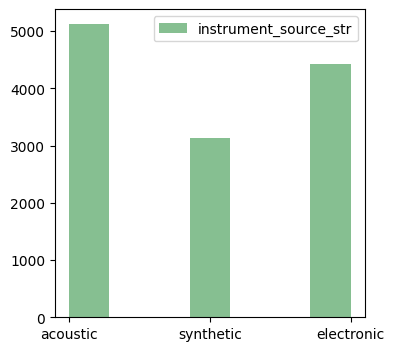

In [ ]:
testFrame=jsonTOcsv('/content/nsynth-test/examples.json')
validationFrame=jsonTOcsv('/content/nsynth-valid/examples.json')
validationFrame['instrument_source_str'].hist(bins=7, grid=False, figsize=(4,4), rwidth=1, color='#86bf91', legend=True)
plt.show()

In [ ]:
testData=np.zeros((len(testFrame), numOfRow, numOfColumn), dtype=np.float32)
testLabel=np.zeros((len(testFrame), numClass), dtype=np.uint8)
validationData=np.zeros((len(validationFrame), numOfRow, numOfColumn), dtype=np.float32)
validationLabel=np.zeros((len(validationFrame), numClass), dtype=np.uint8)

testData, testLabel = setData(testData, testLabel, testFrame.index, '/content/nsynth-test/audio/', testFrame['instrument_source_str'])
validationData, validationLabel = setData(validationData, validationLabel, validationFrame.index, '/content/nsynth-valid/audio/', validationFrame['instrument_source_str'])

deleteTestList=dataControl(testData)
testData=np.delete(testData,deleteTestList, axis=0)
testLabel=np.delete(testLabel, deleteTestList, axis=0)
testData=testData.reshape(len(testData), numOfRow, numOfColumn,1)

deleteValList=dataControl(validationData)
validationData=np.delete(validationData, deleteValList, axis=0)
validationLabel=np.delete(validationLabel, deleteValList, axis=0)
validationData=validationData.reshape(len(validationData), numOfRow, numOfColumn,1)

print(f'\nShape Of validation Data : {validationData.shape}')
print(f'Shape Of test Data : {testData.shape}')

Data Checking: 100%|██████████| 12678/12678 [03:15<00:00, 64.95it/s]



Shape Of validation Data : (12678, 1025, 42, 1)
Shape Of test Data : (4096, 1025, 42, 1)


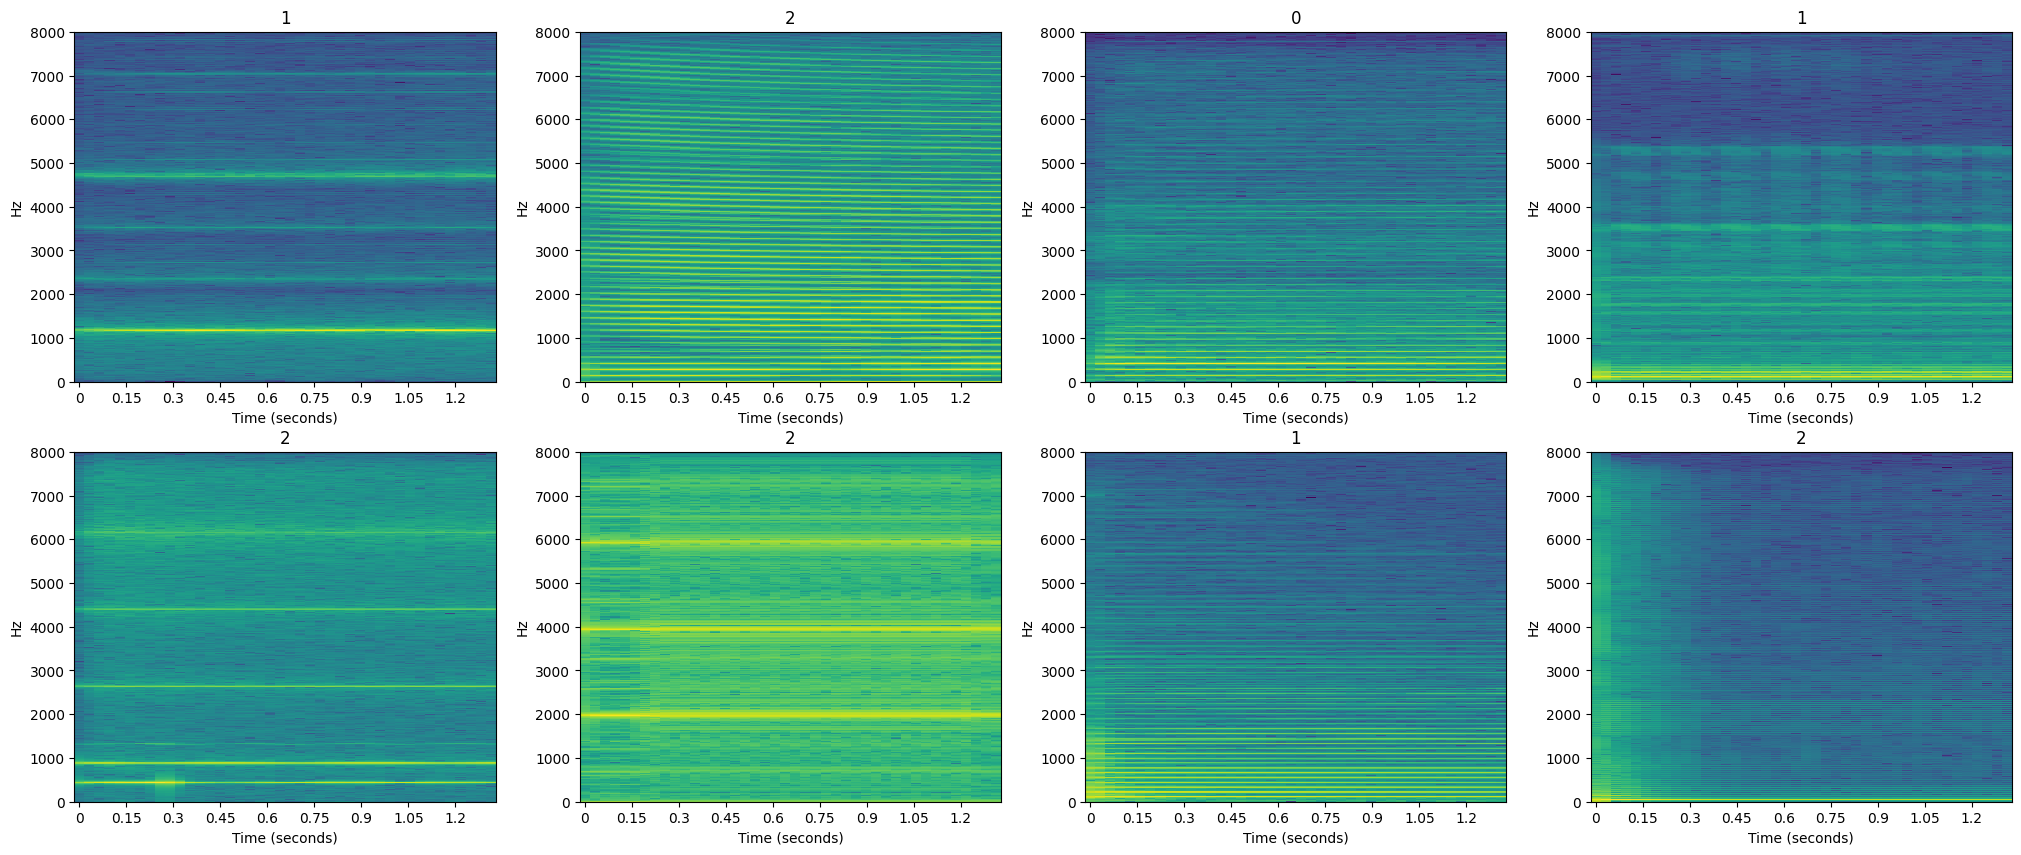

In [ ]:
drawSpec(validationData, validationLabel)

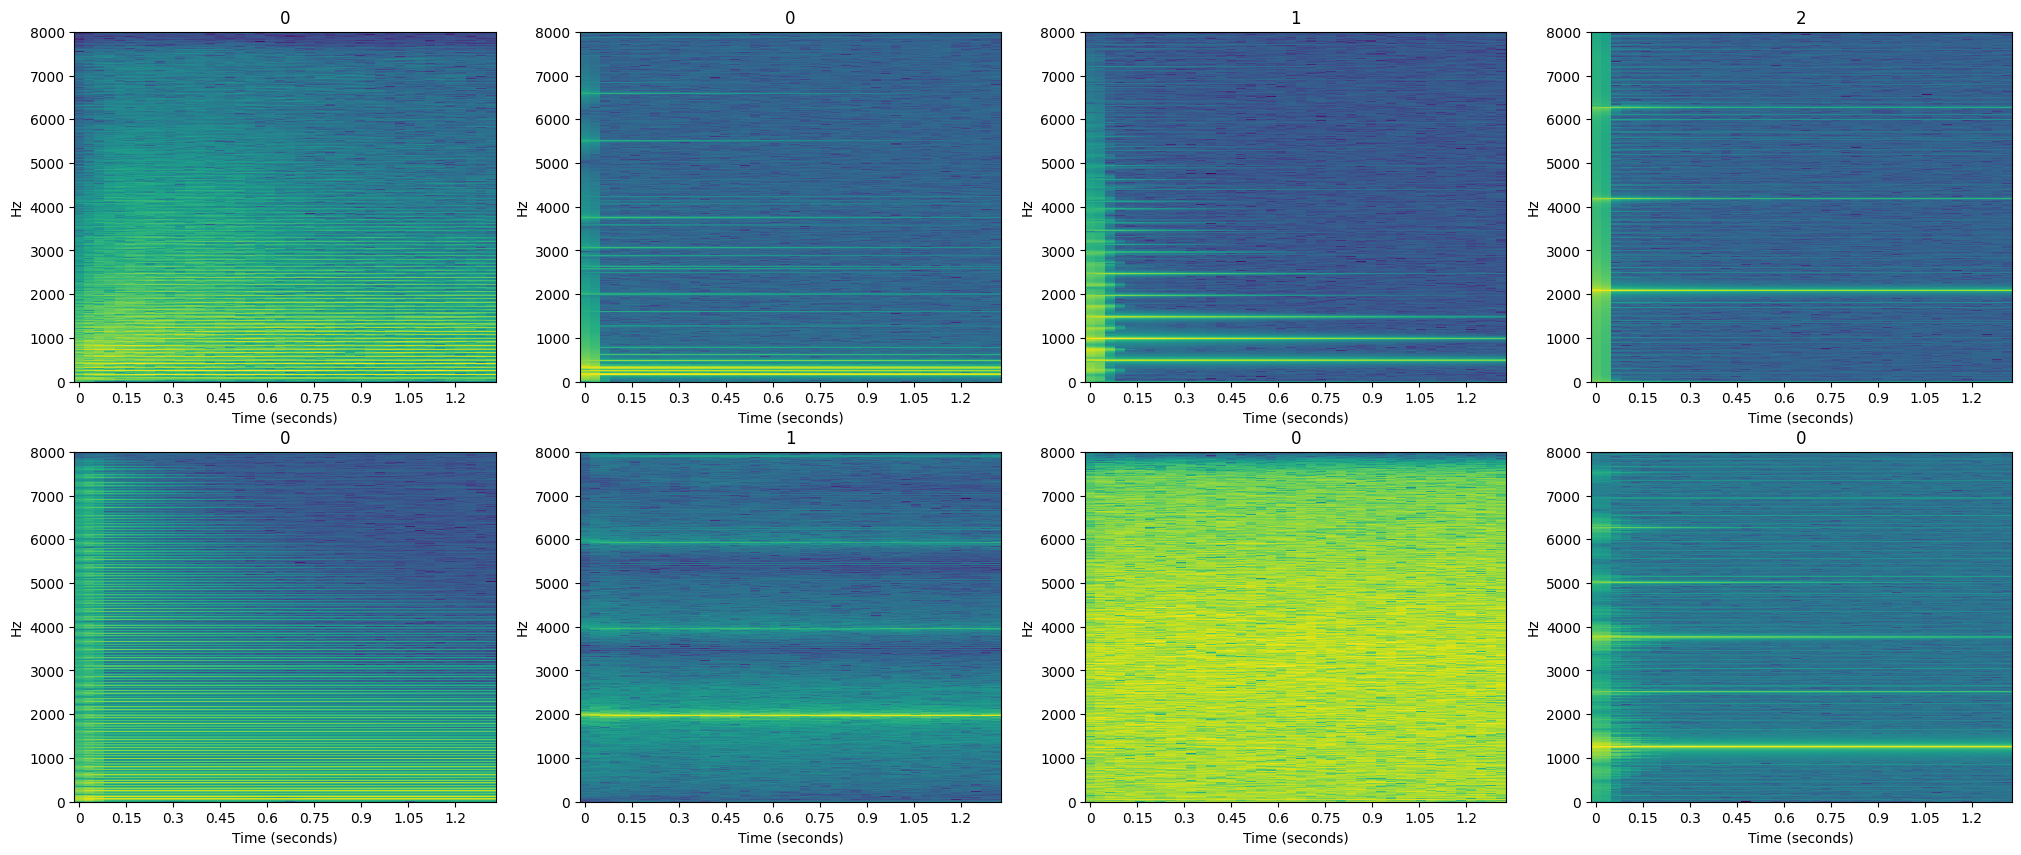

In [ ]:
drawSpec(testData, testLabel)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, Dropout, Resizing, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

def buildModel(inputAudio):

  layer1 = Conv2D(32, 3, activation='relu')(inputAudio)  
  layerb = BatchNormalization()(layer1)
  layer2 = MaxPooling2D()(layerb)
  layerd = Dropout(0.25)(layer2)
  layer3 = Conv2D(32, 3, activation='relu')(layerd)  
  layer4 = MaxPooling2D()(layer3)
  layerd1 = Dropout(0.25)(layer4)
  layer5 = Conv2D(32, 3, activation='relu')(layerd1)
  layer6 = MaxPooling2D()(layer5)  
  layerd2 = Dropout(0.25)(layer6)
  layer7 = Conv2D(32, 3, activation='relu')(layerd2)
  #layer8 = MaxPooling2D()(layer7)  
  layer9 = Dropout(0.25)(layer7)   
  layer10 = Flatten()(layer9)
  layer11 = Dense(512, activation='relu')(layer10)
  layerd3 = Dropout(0.25)(layer11)  
  layer13 = Dense(128, activation='relu')(layerd3)   
  layerd4 = Dropout(0.25)(layer13)  
  layer14 = Dense(3, activation='softmax')(layerd4) 

  return layer14

numOfRow=1025
numOfColumn=42
inputSignal = Input(shape=(numOfRow, numOfColumn, 1))
model=Model(inputs=inputSignal, outputs=buildModel(inputSignal))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1025, 42, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 1023, 40, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 1023, 40, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 511, 20, 32)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 511, 20, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 509, 18, 32)       9248  

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath='/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Models/Model_Synth_detect.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',verbose=2, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

batch_size=32
epochs=30

hist=model.fit( validationData,
                validationLabel,
                epochs=epochs,
                shuffle=True,
                batch_size=batch_size,
                verbose=2,
                validation_split=0.15,
                callbacks=callbacks_list)

Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.73764, saving model to /content/gdrive/MyDrive/TinySOL Musical Note Recognation/Models/Model_Synth_detect.h5
337/337 - 38s - loss: 0.8341 - accuracy: 0.6296 - val_loss: 0.6670 - val_accuracy: 0.7376 - 38s/epoch - 113ms/step
Epoch 2/30

Epoch 2: val_accuracy improved from 0.73764 to 0.82808, saving model to /content/gdrive/MyDrive/TinySOL Musical Note Recognation/Models/Model_Synth_detect.h5
337/337 - 23s - loss: 0.4881 - accuracy: 0.7974 - val_loss: 0.4401 - val_accuracy: 0.8281 - 23s/epoch - 69ms/step
Epoch 3/30

Epoch 3: val_accuracy improved from 0.82808 to 0.90326, saving model to /content/gdrive/MyDrive/TinySOL Musical Note Recognation/Models/Model_Synth_detect.h5
337/337 - 23s - loss: 0.3310 - accuracy: 0.8725 - val_loss: 0.2586 - val_accuracy: 0.9033 - 23s/epoch - 67ms/step
Epoch 4/30

Epoch 4: val_accuracy improved from 0.90326 to 0.93375, saving model to /content/gdrive/MyDrive/TinySOL Musical Note Recognation/Models/Mo

In [ ]:
filepath='/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Models/Model_Synth_detect.h5'
predModel=Model(inputs=inputSignal, outputs=buildModel(inputSignal))
predModel.load_weights(filepath)
predModel.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

test_dataset = tf.data.Dataset.from_tensor_slices((testData, testLabel))
test_dataset = test_dataset.batch(32)
result = predModel.evaluate(test_dataset)

128/128 [==============================] - 2s 11ms/step - loss: 0.0643 - accuracy: 0.9963


In [ ]:
predictions=predModel.predict(testData)
falsePredIndex=[index for index, (pred,real) in enumerate(zip(predictions,testLabel)) if np.where(pred==pred.max())[0][0]!=np.where(real==1)[0][0]]
print(f'Number Of Incorrectly Predicted Data : {len(falsePredIndex)}')

128/128 [==============================] - 1s 9ms/step
Number Of Incorrectly Predicted Data : 15


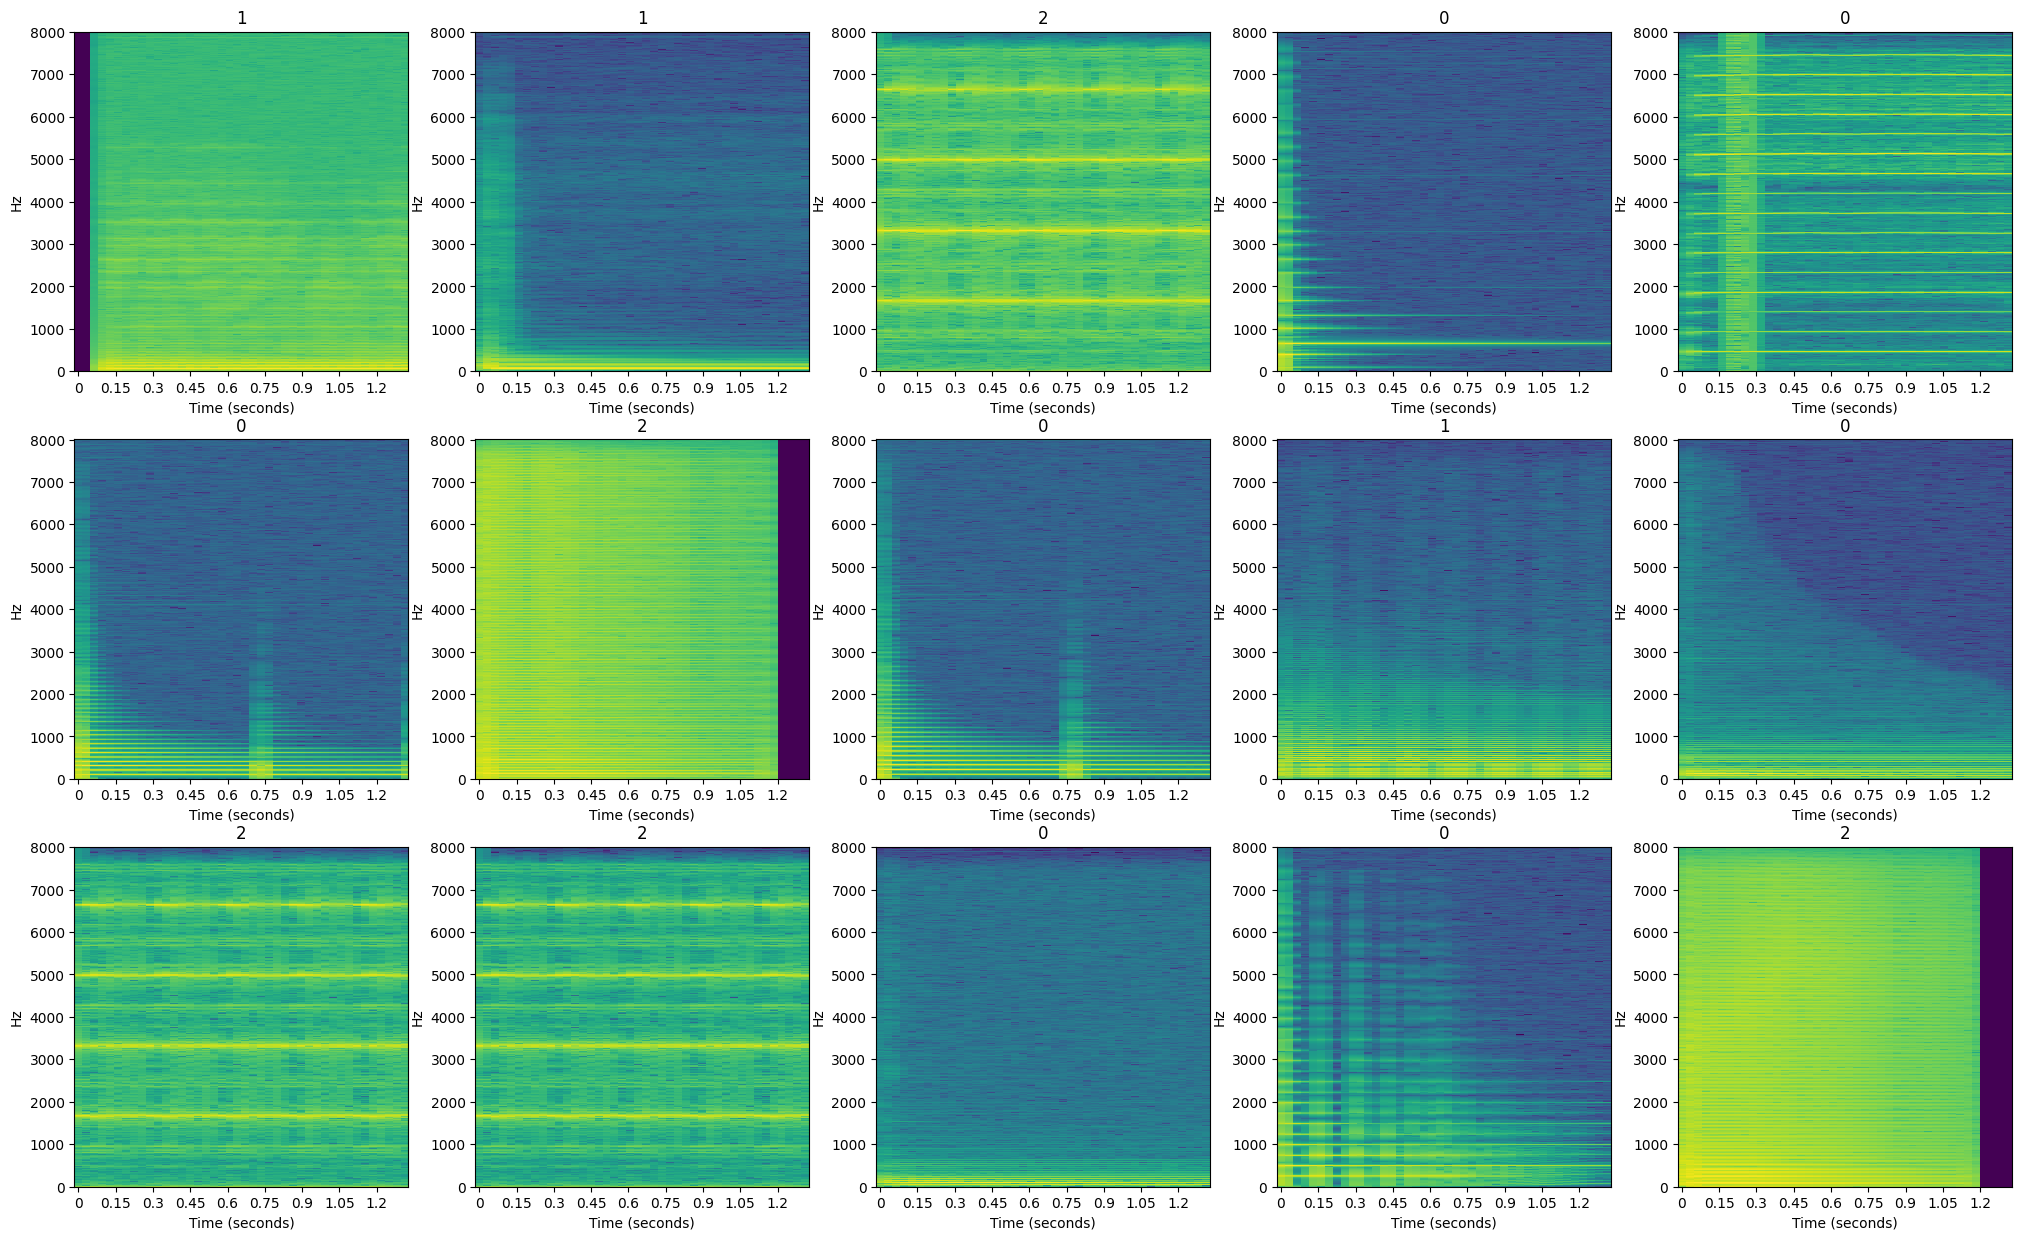

In [ ]:
plt.figure(figsize=(25,15))
for index in range(15):  
  plt.subplot(3, 5, index+1)
  librosa.display.specshow(testData[falsePredIndex[index]].reshape(numOfRow,numOfColumn), sr=16000, 
                            hop_length=2048//4, x_axis='s', y_axis='hz', cmap='viridis')
  plt.title(np.where(testLabel[falsePredIndex[index]]==1)[0][0])
plt.show()